## About
This notebook calculates the S/T mean for membrane vs. non-membrane ("soluble") proteins.

In [9]:
import numpy as np
import matplotlib
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta

from shephard.interfaces import si_proteins, si_protein_attributes
from shephard import Proteome

from scipy.stats import ttest_ind

def cast_attributes(obj, include=[], exclude=[], cast_type=float):
    if len(include) > 0:
        for a in include:
            if a in obj.attributes:
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
    if len(exclude) > 0:
        for a in obj.attributes:

            try:
                if a not in exclude:
                    obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
            except ValueError as e:
                print(f'on {a}')
                raise e


def peval(pval,n=1):
    if pval < 0.00001/n:
        return('****')
    elif pval < 0.0001/n:
        return('***')
    elif pval < 0.001/n:
        return('**')
    elif pval < 0.01/n:
        return('*')
    else:
        return('ns')

# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)


In [10]:
yp = Proteome()
si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_all_v2.tsv')
#si_protein_attributes.add_protein_attributes_from_file(yp,'../surface_analysis/yeast_af2/sequence_annotations/shprd_protein_attribute_subcellular_localization.tsv')



In [11]:
# cast protein attributes 
for p in yp:
    cast_attributes(p, exclude=['lip_color', 'non_ref_score', 'refoldable', 'non_ref', 'nonrefoldable','subcellular_localization','membrane_protein'])

In [12]:
soluble = []
membrane = []

for p in yp:
    if p.attribute('membrane_protein') == 'True':
        membrane.append(p.attribute('S_over_T_mean'))
    else:
        soluble.append(p.attribute('S_over_T_mean'))

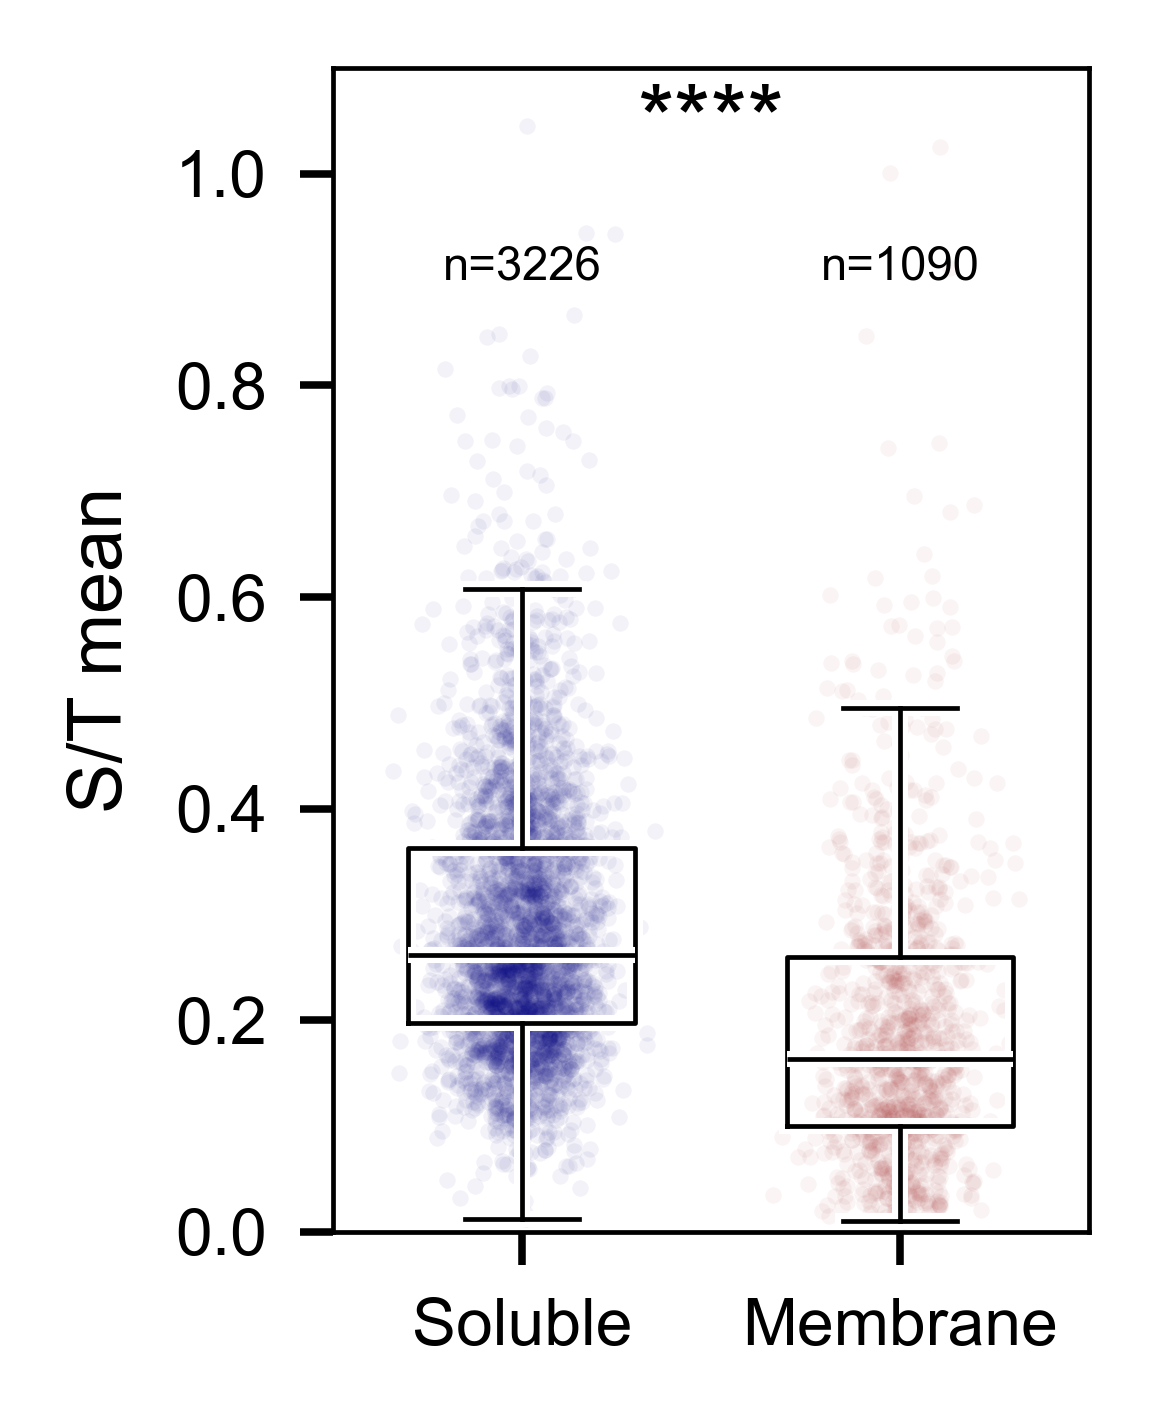

In [13]:
color='navy'
alpha=0.05
s=3
figure(None, (1.8,2.2), dpi=340)
pos = 1
scatter_pos = np.random.randn(len(soluble))*0.1+pos
plt.scatter(scatter_pos, soluble, s=s, alpha=alpha, c=color,linewidth=0)

# once for white outline
boxprops = dict(linewidth=1.7,alpha=1, color='w')
plt.boxplot(soluble, positions=[pos],widths=[0.6],showfliers=False, boxprops=boxprops,medianprops=boxprops,whiskerprops=boxprops, capprops=boxprops)

# again for black inner
boxprops = dict(linewidth=0.5,alpha=1, color='k')
plt.boxplot(soluble, positions=[pos],widths=[0.6],showfliers=False, boxprops=boxprops,medianprops=boxprops,whiskerprops=boxprops, capprops=boxprops)


color='brown'
pos = 2
scatter_pos = np.random.randn(len(membrane))*0.1+pos
plt.scatter(scatter_pos, membrane, s=s, alpha=alpha, c=color,linewidth=0)

boxprops = dict(linewidth=1.7,alpha=1, color='w')
plt.boxplot(membrane, positions=[pos],widths=[0.6],showfliers=False, boxprops=boxprops,medianprops=boxprops, whiskerprops=boxprops,capprops=boxprops)

boxprops = dict(linewidth=0.5,alpha=1, color='k')
plt.boxplot(membrane, positions=[pos],widths=[0.6],showfliers=False, boxprops=boxprops,medianprops=boxprops, whiskerprops=boxprops,capprops=boxprops)

plt.ylim([0,1.1])
plt.xticks([1,2],['Soluble','Membrane'],fontsize=7,rotation=0)

plt.yticks(fontsize=7)
plt.ylabel('S/T mean', fontsize=8)

plt.text(1.5, 1.02, peval(pval.pvalue),ha='center')
plt.text(1, 0.9, f"n={len(soluble)}",ha='center', fontsize=5)
plt.text(2, 0.9, f"n={len(membrane)}",ha='center', fontsize=5)
plt.tight_layout()
plt.savefig('outfigures/membrane_vs_non_membrane.pdf')

In [15]:
fh1 = open('outdata/membrane_protein_uids.txt','w')
fh2 = open('outdata/soluble_protein_uids.txt','w')
fh3 = open('outdata/all_protein_uids.txt','w')
for p in yp:
    if p.attribute('membrane_protein') =='False':
        fh2.write(f"{p.unique_ID}\n")
    else:
        fh1.write(f"{p.unique_ID}\n")
    fh3.write(f"{p.unique_ID}\n")

fh1.close()
fh2.close()
fh3.close()
